In [325]:
import numpy as np
from scipy.stats import norm

In [326]:
# option pricing logic

In [327]:
N = norm.cdf

def BS_CALL(S, K, T, r, sigma):
    d1 = (np.log(S/K) + (r + sigma**2/2)*T) / (sigma*np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    return S * N(d1) - K * np.exp(-r*T)* N(d2)

def BS_PUT(S, K, T, r, sigma):
    d1 = (np.log(S/K) + (r + sigma**2/2)*T) / (sigma*np.sqrt(T))
    d2 = d1 - sigma* np.sqrt(T)
    return K*np.exp(-r*T)*N(-d2) - S*N(-d1)    
    
    
def merton_jump_call(S, K, T, r, sigma, m , v, lam):
    p = 0

    for k in range(5):
        r_k = r - lam*(m-1) + (k*np.log(m) ) / T
        sigma_k = np.sqrt( sigma**2 + (k* v** 2) / T)
        
        
        #delta += (np.exp(-m*lam*T) * (m*lam*T)**k / (k_fact)) * (np.log(S/K) + (r + sigma**2/2)*T) / (sigma*np.sqrt(T))
        
        k_fact = np.math.factorial(k)
        p += (np.exp(-m*lam*T) * (m*lam*T)**k / (k_fact))  * BS_CALL(S, K, T, r_k, sigma_k)
    
    return p

def merton_jump_put(S, K, T, r, sigma, m , v, lam):
    p = 0 # price of option
    for k in range(40):
        r_k = r - lam*(m-1) + (k*np.log(m) ) / T
        sigma_k = np.sqrt( sigma**2 + (k* v** 2) / T)
        k_fact = np.math.factorial(k) # 
        p += (np.exp(-m*lam*T) * (m*lam*T)**k / (k_fact)) \
                    * BS_PUT(S, K, T, r_k, sigma_k)
    return p

In [328]:
# calculate delta using jump diffusion:

In [329]:
def merton_jump_call_d1(S, K, T, r, sigma, m , v, lam):
    d1 = 0

    for k in range(5):
        r_k = r - lam*(m-1) + (k*np.log(m) ) / T
        sigma_k = np.sqrt( sigma**2 + (k* v** 2) / T)

        k_fact = np.math.factorial(k)

        d1 += (np.exp(-m*lam*T) * (m*lam*T)**k / (k_fact)) * (np.log(S/K) + (r + sigma**2/2)*T) / (sigma*np.sqrt(T))


        
    return d1

In [330]:
# @ t0, user decides to replicate option contract with parameters:

In [331]:
S = 1000 #current price
K = 800 #strike
T = 1 #time to maturity
r = 0.1 #risk free rate
m = 1 # mean of jump size
v = 0.1 # standard deviation of jump
lam = 1 # intensity of jump i.e. number of jumps per annum
sigma = 0.8 # annual standard deviation , for weiner process

# theoretical price of option
c = merton_jump_call(S, K, T, r, sigma, m , v, lam)
print(c)

426.40898571154156


In [332]:
# d1 given by jump diffusion
d1 = merton_jump_call_d1(S, K, T, r, sigma, m , v, lam)
print(d1)

0.8009871805355074


In [333]:
# delta is how much of underlying asset must be bought (0.69 ETH)
delta = N(d1)
print(delta)

0.7884304663373789


In [334]:
# user deposits amount to replicate 1 ETH call contract 
# price of 1 ETH + theoretical price of contract
total_value = S + c
print(total_value)

1426.4089857115416


In [335]:
# tokenA is non volatile asset USDT
# tokenB is volatile asset ETH

In [336]:
tokenA = total_value - (delta*S)
tokenA

637.9785193741627

In [337]:
tokenB = delta
tokenB 

0.7884304663373789

In [338]:
# @ t0
# 0.69 ETH 
# 647 USDT

# total_value = 1346.66

In [339]:
tokenA + delta * S

1426.4089857115416

In [340]:
# t1 price changes from 1000 to 1100, let's see how delta changes:

In [341]:
S = 1000 #current price
K = 800 #strike
T = 1 #time to maturity
r = 0.1 #risk free rate
m = 1 # mean of jump size
v = 0.1 # standard deviation of jump
lam = 1 # intensity of jump i.e. number of jumps per annum
sigma = 0.8 # annual standard deviation , for weiner process

In [342]:
# d1 given by jump diffusion
d1 = merton_jump_call_d1(S, K, T, r, sigma, m , v, lam)

delta = N(d1)
print(delta)

0.7884304663373789


In [343]:
# tokenA @ t0
tokenA

637.9785193741627

In [344]:
# tokenB @ t0
tokenB

0.7884304663373789

In [345]:
# tokenA @ t1
tokenA -= (delta - tokenB) * S
tokenA

637.9785193741627

In [346]:
# tokenB @ t1
tokenB = delta
tokenB

0.7884304663373789

In [347]:
# total value
tokenA + tokenB*S

1426.4089857115416

In [348]:
# t1
# 0.77 ETH
# 557 USDT
# total value = 1486.57 USDT

In [349]:
# init pool 

In [405]:
pool = {"K":0,"T":0,"r":0,"m":0,"v":0,"lam":0,"sigma":0,"tokenA":0,"tokenB":0,"totalV":0,"amount":0}

In [406]:
pool

{'K': 0,
 'T': 0,
 'r': 0,
 'm': 0,
 'v': 0,
 'lam': 0,
 'sigma': 0,
 'tokenA': 0,
 'tokenB': 0,
 'totalV': 0,
 'amount': 0}

In [407]:
def weightedAVG(v1,a1,v2,a2):
    return ((v1*a1) + (v2*a2)) / (a1+ a2)

In [408]:
def addPosition(S,K,T,r,m,v,lam,sigma,amount):
    
    c = merton_jump_call(S, K, T, r, sigma, m , v, lam)
    
    d1 = merton_jump_call_d1(S, K, T, r, sigma, m , v, lam)
    
    delta = N(d1)    # kirill: in merton's case delta isn't computed like this I think
    
    totalV = (S + c) * amount
    
    tokenA = totalV - (delta*S)
    tokenB = delta * amount
    
    
    # current amount
    currentAmount = pool["totalV"]
    
    # pool value before new position
    currentK = pool["K"]
    currentT = pool["T"]
    currentr = pool["r"]
    currentm = pool["m"]
    currentv = pool["v"]
    currentlam = pool["lam"]
    currentsigma = pool["sigma"]
    
    # get new updated value
    pK = weightedAVG(currentK,currentAmount,K,totalV)
    pT = weightedAVG(currentT,currentAmount,T,totalV)
    pr = weightedAVG(currentr,currentAmount,r,totalV)
    pm = weightedAVG(currentm,currentAmount,m,totalV)
    pv = weightedAVG(currentv,currentAmount,v,totalV)
    plam = weightedAVG(currentlam,currentAmount,lam,totalV)
    psigma = weightedAVG(currentsigma,currentAmount,sigma,totalV)
    
    # update pool values
    pool["K"] = pK
    pool["T"] = pT
    pool["r"] = pr
    pool["m"] = pm
    pool["v"] = pv
    pool["lam"] = plam
    pool["sigma"] = psigma
    
    # add new amounts of token to pool
    
    pool["tokenA"] += tokenA
    pool["tokenB"] += tokenB

    # add new amount to pool (for easier visualization)
    pool["totalV"] += totalV   
    pool["amount"] += amount
    

In [409]:
S = 1000 #current price

K = 1000 #strike
T = 1 #time to maturity
r = 0.1 #risk free rate
m = 1 # mean of jump size
v = 0.1 # standard deviation of jump
lam = 1 # intensity of jump i.e. number of jumps per annum
sigma = 0.8 # annual standard deviation , for weiner process

amount = 1

In [410]:
addPosition(S,K,T,r,m,v,lam,sigma,amount)

In [411]:
pool

{'K': 1000.0,
 'T': 1.0,
 'r': 0.1,
 'm': 1.0,
 'v': 0.1,
 'lam': 1.0,
 'sigma': 0.8,
 'tokenA': 647.1286156959065,
 'tokenB': 0.6995402146911245,
 'totalV': 1346.668830387031,
 'amount': 1}

In [412]:
tokenA = pool["tokenA"]
tokenB = pool["tokenB"]

def poolValue(tokenA,tokenB,S):
    return tokenA + tokenB * S

In [413]:
poolValue(tokenA,tokenB,1100)

1416.6228518561434

In [414]:
# Delta Hedge pool

In [415]:
def deltaHedge(S):  
    K = pool["K"]
    T = pool["T"]
    r = pool["r"]
    sigma = pool["sigma"]
    m = pool["m"]
    v = pool["v"]
    lam = pool["lam"]

    d1 = merton_jump_call_d1(S, K, T, r, sigma, m , v, lam)

    delta = N(d1)
    
    tokenA = pool["tokenA"]
    tokenA -= abs(delta - pool["tokenB"]/pool["amount"]) * S
    tokenB = delta * pool["amount"] 

    pool["tokenA"] = tokenA
    pool["tokenB"] = tokenB
    
    totalV = tokenA + tokenB * S
    pool["totalV"] = tokenA + tokenB * S

    print("updated delta", delta)
    print("tokenA", tokenA)
    print("tokenB", tokenB)
    print("totalV", totalV)

In [416]:
deltaHedge(1100)

updated delta 0.7394920720819695
tokenA 603.181572565977
tokenB 0.7394920720819695
totalV 1416.6228518561434


In [362]:
### Remove position

In [363]:
def delete(v1,a1,v2,a2):
    a1 *= -1
    return ((v1*a1) + (v2*a2)) / (a1+ a2)

In [364]:
def removePosition(S,K,T,r,m,v,lam,sigma,amount):
    
    c = merton_jump_call(S, K, T, r, sigma, m , v, lam)
    
    d1 = merton_jump_call_d1(S, K, T, r, sigma, m , v, lam)
    
    delta = N(d1)    
    
    totalV = (S + c) * amount
    
    tokenA = totalV - (delta*S)
    tokenB = delta * amount
    
    
    # current amount
    currentAmount = pool["totalV"]
    
    # pool value before new position
    currentK = pool["K"]
    currentT = pool["T"]
    currentr = pool["r"]
    currentm = pool["m"]
    currentv = pool["v"]
    currentlam = pool["lam"]
    currentsigma = pool["sigma"]
    
    # get new updated value
    pK = delete(currentK,currentAmount,K,amount)
    pT = delete(currentT,currentAmount,T,amount)
    pr = delete(currentr,currentAmount,r,amount)
    pm = delete(currentm,currentAmount,m,amount)
    pv = delete(currentv,currentAmount,v,amount)
    plam = delete(currentlam,currentAmount,lam,amount)
    psigma = delete(currentsigma,currentAmount,sigma,amount)
    
    # update pool values
    pool["K"] = pK
    pool["T"] = pT
    pool["r"] = pr
    pool["m"] = pm
    pool["v"] = pv
    pool["lam"] = plam
    pool["sigma"] = psigma

    pool["tokenA"] -= tokenA
    pool["tokenB"] -= tokenB

    # add new amount to pool (for easier visualization)
    pool["totalV"] -= totalV 
    
    pool["amount"] -= amount

In [365]:
S = 1100 #current price

K = 800 #strike
T = 1 #time to maturity
r = 0.1 #risk free rate
m = 1 # mean of jump size
v = 0.1 # standard deviation of jump
lam = 1 # intensity of jump i.e. number of jumps per annum
sigma = 0.8 # annual standard deviation , for weiner process

amount = 1

c = merton_jump_call(S, K, T, r, sigma, m , v, lam)
c

506.7208926090395

In [366]:
removePosition(S,K,T,r,m,v,lam,sigma,amount)

In [367]:
pool

{'K': 1000.0009290808276,
 'T': 1.0,
 'r': 0.10000000000000002,
 'm': 1.0,
 'v': 0.10000000000000002,
 'lam': 1.0,
 'sigma': 0.8000000000000002,
 'tokenA': 133219.92043721324,
 'tokenB': 73.12807489097852,
 'totalV': 213660.8028172896,
 'amount': 99}

In [368]:
# kirill

from scipy.stats import norm
import math
import random

N = norm.cdf

def BS_DELTA_CALL(S, K, T, r, sigma):
    d1 = (np.log(S/K) + (r + sigma**2/2)*T) / (sigma*np.sqrt(T))
    return N(d1)

def BS_DELTA_PUT(S, K, T, r, sigma):
    return BS_DELTA_CALL(S, K, T, r, sigma) - 1

def BS_DELTA(S, K, T, r, sigma, _type):
    if _type == 'call':
        return BS_DELTA_CALL(S, K, T, r, sigma)
    elif _type == 'put':
        return BS_DELTA_CALL(S, K, T, r, sigma) - 1
    

In [369]:
random.seed()
random.random()

0.09026033483314733

In [370]:
random.randrange(200, 5000, 50)

2250

In [371]:
# testing the deviation 

# from functools import reduce

S = 2700
maturity = 10 / 365
pool_size = 10

strikes = [random.randrange(200, 5000, 50) for i in range(pool_size)]

sigmas = [random.randrange(20, 80) / 100 for i in range(pool_size)]
# maturities = [random.randrange(1, 100) / 365 for i in range(pool_size)] 


maturities = [maturity] * pool_size

In [372]:
amounts = [random.randrange(1, 100) for i in range(pool_size)]
# types = [random.choice(['call', 'put']) for i in range(pool_size)]


In [373]:
# inputs (S, K, T, r, sigma)

deltas = [round(amounts[i]*BS_DELTA(S, strikes[i], maturities[i], 0.1, sigmas[i], 'call'), 4)
          for i in range(pool_size)]

In [374]:
total_delta_to_trade = sum(deltas)
total_delta_to_trade

282.16159999999996

In [375]:
w_avg_strike = sum([strikes[i]*amounts[i] for i in range(pool_size)]) / sum(amounts)
w_avg_strike

2838.0664652567975

In [376]:
w_avg_sigma = sum([sigmas[i]*amounts[i] for i in range(pool_size)]) / sum(amounts)
w_avg_sigma

0.55297583081571

In [377]:
avg_strike = sum([strikes[i] for i in range(pool_size)]) / pool_size
avg_strike

2845.0

In [378]:
avg_sigma = sum([sigmas[i] for i in range(pool_size)]) / pool_size
avg_sigma

0.5760000000000001

In [379]:
S = 3238

In [380]:
total_delta_to_trade = sum(deltas)
print('right total delta to trade:', total_delta_to_trade)


w_avg_strike = sum([strikes[i]*amounts[i] for i in range(pool_size)]) / sum(amounts)
w_avg_sigma = sum([sigmas[i]*amounts[i] for i in range(pool_size)]) / sum(amounts)

print('---\navg_strike: {}, avg_sigma: {}\n---'.format(w_avg_strike, w_avg_sigma))

weighted_avg_delta = BS_DELTA_CALL(S, w_avg_strike, maturity, 0, w_avg_sigma)
print('weighted_avg_delta:', weighted_avg_delta * sum(amounts))

right total delta to trade: 282.16159999999996
---
avg_strike: 2838.0664652567975, avg_sigma: 0.55297583081571
---
weighted_avg_delta: 616.5694564472165


In [381]:
weighted_avg_delta = BS_DELTA_CALL(2000, w_avg_strike, maturity, 0, w_avg_sigma)
print(weighted_avg_delta * sum(amounts))

0.052352476824476746


In [382]:
delta_func = []


S = 50
for i in range(100):
    weighted_avg_delta = BS_DELTA_CALL(S, w_avg_strike, maturity, 0.1, w_avg_sigma)
    
    delta_func.append(weighted_avg_delta * sum(amounts))
    
    S += 50


    
    
    
    

    

In [383]:
delta_func[-1]

661.9999998749659

In [384]:
# might take a bit to calculate

correct_delta = []

S = 50

for i in range(100):
    
    
    deltas = [round(amounts[i]*BS_DELTA(S, strikes[i], maturities[i], 0.1, sigmas[i], 'call'), 4)
          for i in range(pool_size)]
    
    correct_delta.append(sum(deltas))
    
    S += 50
    
    

In [385]:
price = []

S = 50

for i in range(100):
    
    price.append(S)
    
    S+=50

In [386]:
import pandas as pd

df = pd.DataFrame(
    {'price': price,
     'correct_delta': correct_delta,
     'delta_func': delta_func
    })

In [387]:
df.set_index('price', inplace=True)

In [388]:
df

,correct_delta,delta_func
price,,
50,0.0000,0.000000e+00
100,0.0000,8.272064e-289
150,0.0000,7.785336e-223
200,0.0000,3.440643e-181
250,0.0000,7.730529e-152
...,...,...
4800,645.1846,6.620000e+02
4850,647.6086,6.620000e+02
4900,649.7227,6.620000e+02


In [419]:
df.pct_change()

,correct_delta,delta_func
price,,
50,NaN,NaN
100,NaN,inf
150,NaN,9.411600e+65
200,NaN,4.419389e+41
250,NaN,2.246827e+29
...,...,...
4800,0.004309,2.904886e-09
4850,0.003757,1.483375e-09
4900,0.003264,7.530774e-10


<AxesSubplot:xlabel='price'>

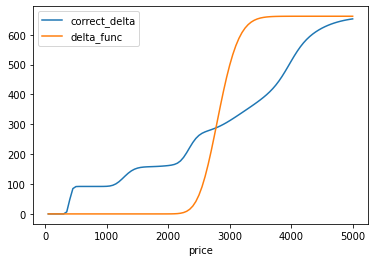

In [389]:
df.plot()

In [ ]:
def weightedAVG(v1,a1,v2,a2):
    return ((v1*a1) + (v2*a2)) / (a1+ a2)

In [ ]:
weightedAVG(10,1,5,10)

In [ ]:
# danilla
def delete(v1,a1,v2,a2):
    avg = weightedAVG(v1,a1,v2,a2)
    return (avg - v2*a2/(a1+a2))*(a1+a2)/v1


In [ ]:
delete(10,1,5,10)

In [ ]:
def weightedAVG(v1,a1,v2,a2):
    return ((v1*a1) + (v2*a2)) / (a1+ a2)

In [ ]:
weightedAVG(12,2,15,10)

In [ ]:
weightedAVG(12,-2,10.333333333333334,12)

In [ ]:
def delete(v1,a1,v2,a2):
    a1 *= -1
    return ((v1*a1) + (v2*a2)) / (a1+ a2)

In [ ]:
delete(12,2,14.5,12)

In [ ]:
def xyz(v1,a1,v2,a2):
    v = v2 - v1
    a = a2 - a1
    
    return a * v / a 

In [ ]:
xyz(10,1,5,10)

In [ ]:
S = 1000 #current price
K = 800 #strike
T = 1 #time to maturity
r = 0.1 #risk free rate
m = 1 # meean of jump size
v = 0.1 # standard deviation of jump
lam = 1 # intensity of jump i.e. number of jumps per annum
sigma = 0.8 # annual standard deviation , for weiner process

# theoretical price of option
c = merton_jump_call(S, K, T, r, sigma, m , v, lam)
print(c)

In [ ]:
weightedAVG(1000,100,800,10000)

In [ ]:
def updatePool(K,T,r,m,v,lam,sigma):
    pool = {"K":K,"T":T,"r":r,"m":m,"v":v,"lam":lam,"sigma":sigma}
    
    

In [ ]:
pool["K"]